In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, fbeta_score, precision_score, recall_score

/Users/mahabub.ahmed.eee/Documents/MLOps/MLOps-Spotify/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
POPULARITY_THRESHOLD = 85
SEED = 42
BETA = 1.5

RECALL_THRESHOLD = 0.7
PRECISION_THRESHOLD = 0.2

# I. Load data

In [3]:
# Download latest version
data_path = kagglehub.dataset_download("amitanshjoshi/spotify-1million-tracks")

print("Path to dataset files:", data_path)

Path to dataset files: /Users/mahabub.ahmed.eee/.cache/kagglehub/datasets/amitanshjoshi/spotify-1million-tracks/versions/1


In [4]:
# I. Load data
data = pd.read_csv(f"{data_path}/spotify_data.csv")
data.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1159764 non-null  int64  
 1   artist_name       1159749 non-null  object 
 2   track_name        1159763 non-null  object 
 3   track_id          1159764 non-null  object 
 4   popularity        1159764 non-null  int64  
 5   year              1159764 non-null  int64  
 6   genre             1159764 non-null  object 
 7   danceability      1159764 non-null  float64
 8   energy            1159764 non-null  float64
 9   key               1159764 non-null  int64  
 10  loudness          1159764 non-null  float64
 11  mode              1159764 non-null  int64  
 12  speechiness       1159764 non-null  float64
 13  acousticness      1159764 non-null  float64
 14  instrumentalness  1159764 non-null  float64
 15  liveness          1159764 non-null  float64
 16  

In [6]:
data.isnull().sum()

Unnamed: 0           0
artist_name         15
track_name           1
track_id             0
popularity           0
year                 0
genre                0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

In [7]:
data.dropna(inplace=True)
data.isnull().sum()

Unnamed: 0          0
artist_name         0
track_name          0
track_id            0
popularity          0
year                0
genre               0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [8]:
data['artist_name'].nunique(), data['track_name'].nunique(), data['track_id'].nunique()

(64158, 882349, 1159748)

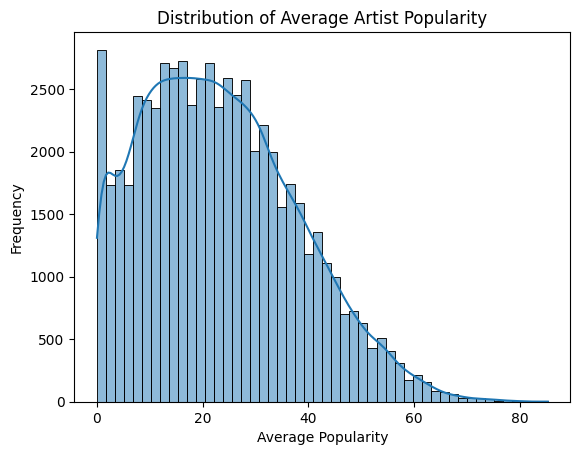

In [9]:
artists_popularity = data.groupby('artist_name')['popularity'].mean().sort_values(ascending=False)
# add columns names (artist_name, average_popularity)
artists_popularity = artists_popularity.reset_index()
artists_popularity.columns = ['artist_name', 'average_popularity']

artists_popularity = artists_popularity[artists_popularity['average_popularity'] > 0]

sns.histplot(artists_popularity['average_popularity'], bins=50, kde=True)
plt.title('Distribution of Average Artist Popularity')
plt.xlabel('Average Popularity')
plt.ylabel('Frequency')
plt.show()

In [10]:
artists_popularity.columns

Index(['artist_name', 'average_popularity'], dtype='object')

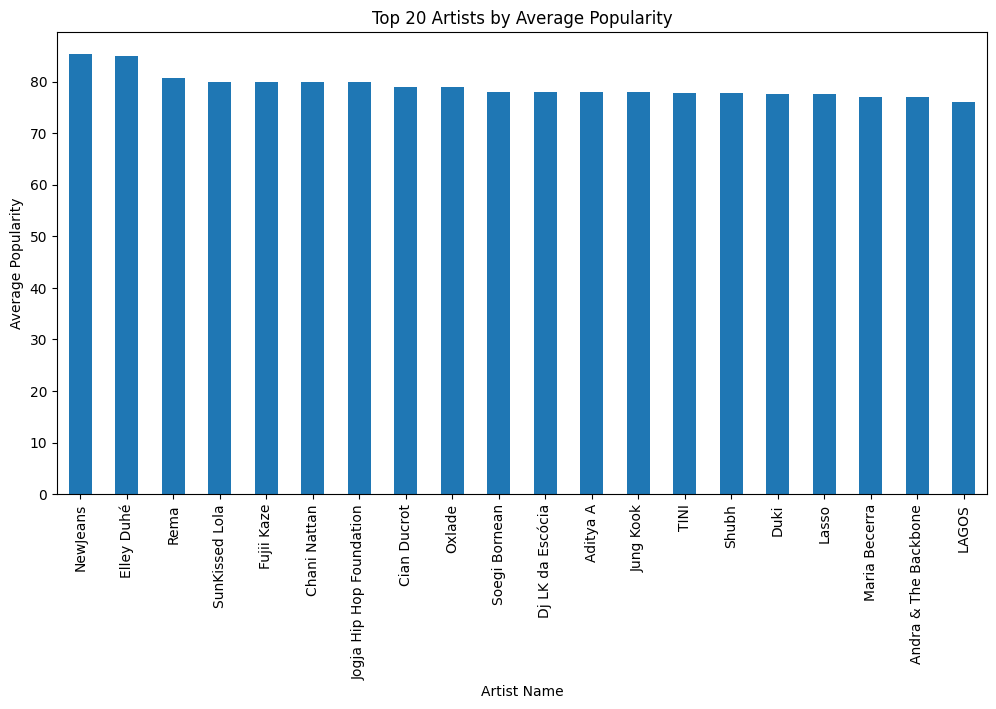

In [11]:
# get the 20 top artists based on average popularity of their songs
top_artists = data.groupby('artist_name')['popularity'].mean().sort_values(ascending=False).head(20)
top_artists.plot(kind='bar', figsize=(12, 6), title='Top 20 Artists by Average Popularity')
plt.xlabel('Artist Name')
plt.ylabel('Average Popularity')
plt.show()

In [12]:
data['genre'].value_counts()

genre
black-metal       21837
gospel            21621
ambient           21389
acoustic          21097
alt-rock          20918
                  ...  
chicago-house      5170
dubstep            4774
detroit-techno     3920
rock               3319
songwriter          589
Name: count, Length: 82, dtype: int64

In [13]:
data = data[data['popularity'] > 0]

# Add nbr of songs from same artist

In [14]:
# add feature for every song, number of songs from the same artist
data['artist_song_count'] = data.groupby('artist_name')['track_id'].transform('count')

## Verdict

In [15]:
# data['verdict'] = (data['popularity'] > POPULARITY_THRESHOLD).astype(int)
# data['verdict'].value_counts()

# let's define verdict as the top threshold percentile of each year
# data['year'] = pd.to_datetime(data['release_date'], errors='coerce').dt.year
# data = data.dropna(subset=['year'])
data['year'] = data['year'].astype(int)
yearly_thresholds = data.groupby('year')['popularity'].quantile(POPULARITY_THRESHOLD / 100).to_dict()
data['verdict'] = data.apply(lambda row: 1 if row['popularity'] >= yearly_thresholds[row['year']] else 0, axis=1)
data['verdict'].value_counts()

verdict
0    844801
1    156556
Name: count, dtype: int64

In [16]:
yearly_thresholds

{2000: 27.0,
 2001: 28.0,
 2002: 29.0,
 2003: 30.0,
 2004: 30.0,
 2005: 31.0,
 2006: 30.0,
 2007: 31.0,
 2008: 31.0,
 2009: 31.0,
 2010: 31.0,
 2011: 32.0,
 2012: 33.0,
 2013: 34.0,
 2014: 36.0,
 2015: 37.0,
 2016: 40.0,
 2017: 41.0,
 2018: 43.0,
 2019: 44.0,
 2020: 45.0,
 2021: 47.0,
 2022: 51.0,
 2023: 43.0}

In [17]:
# verdict 1 percentage
verdict_1_percentage = (data['verdict'].sum() / data.shape[0]) * 100
print(f"Percentage of tracks with popularity > {POPULARITY_THRESHOLD}: {verdict_1_percentage:.2f}%")

Percentage of tracks with popularity > 85: 15.63%


# Ibis. Heat Map

In [18]:
# drop the first 4 columns
data_4_heat_map = data.iloc[:, 4:]
data_4_heat_map.drop(['genre', 'mode', 'verdict'], axis=1, inplace=True)
data_4_heat_map.head()

,popularity,year,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_song_count
0,68,2012,0.483,0.303,4,-10.058,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3,193
1,50,2012,0.572,0.454,3,-10.286,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4,193
2,57,2012,0.409,0.234,3,-13.711,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4,61
3,58,2012,0.392,0.251,10,-9.845,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4,337
4,54,2012,0.430,0.791,6,-5.419,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4,66


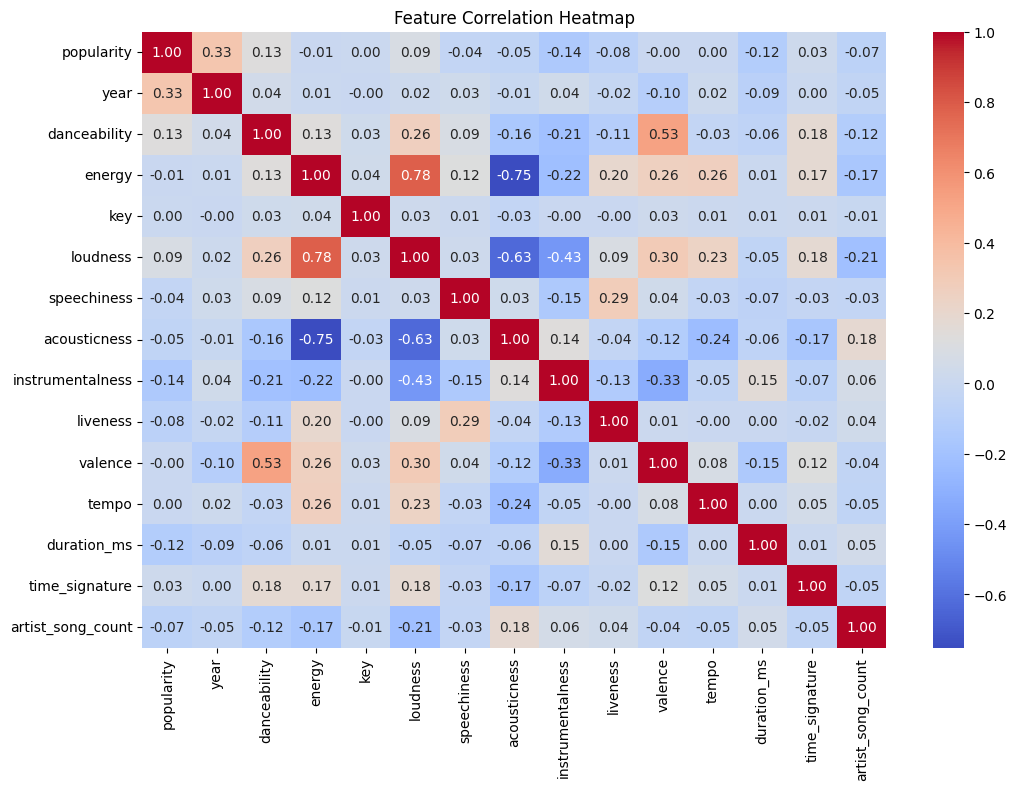

In [19]:
# plot heatmap of correlations
plt.figure(figsize=(12, 8))
correlation_matrix = data_4_heat_map.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# II. Visualization

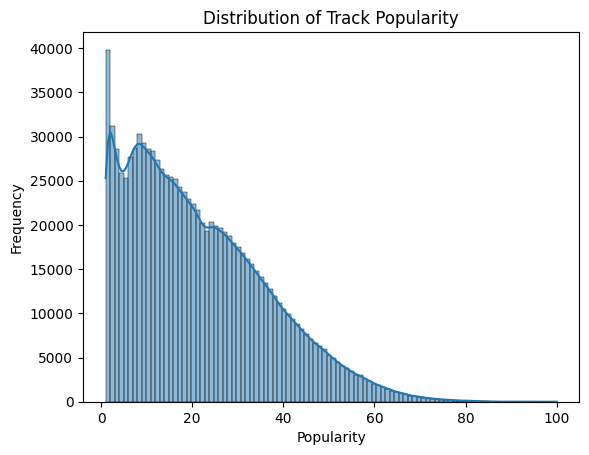

In [20]:
# plot popularity distribution
sns.histplot(data['popularity'], bins=100, kde=True)
plt.title('Distribution of Track Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

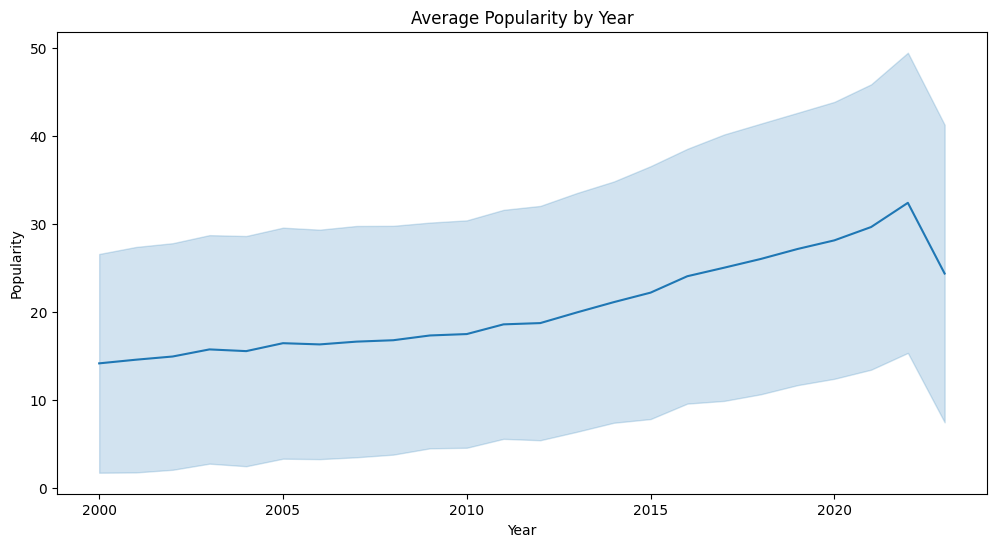

In [21]:
# plot years avg popularity using a line plot including intervals
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='popularity', data=data, errorbar='sd')
plt.title('Average Popularity by Year')
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.show()

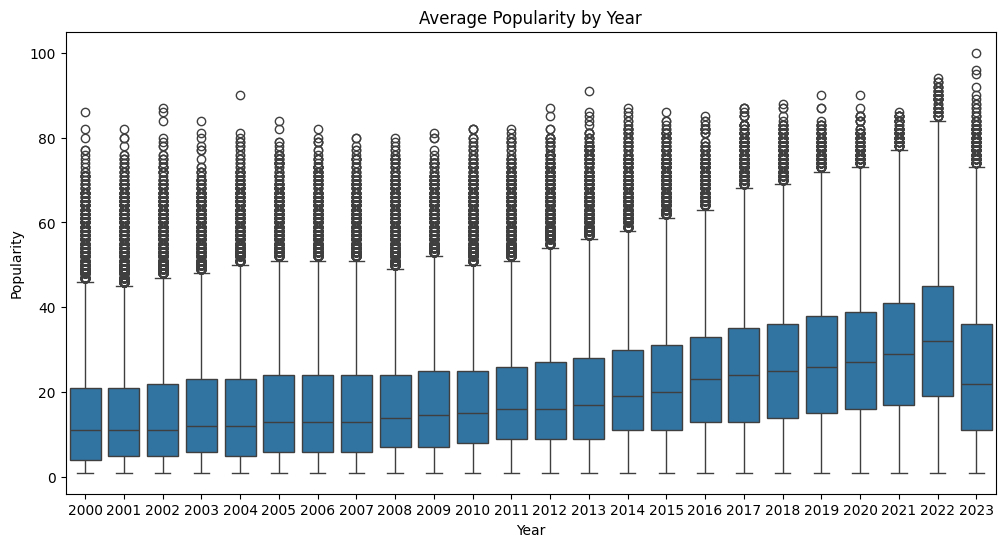

In [22]:
# plot years avg popularity using a line plot including intervals
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='popularity', data=data)
plt.title('Average Popularity by Year')
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.show()

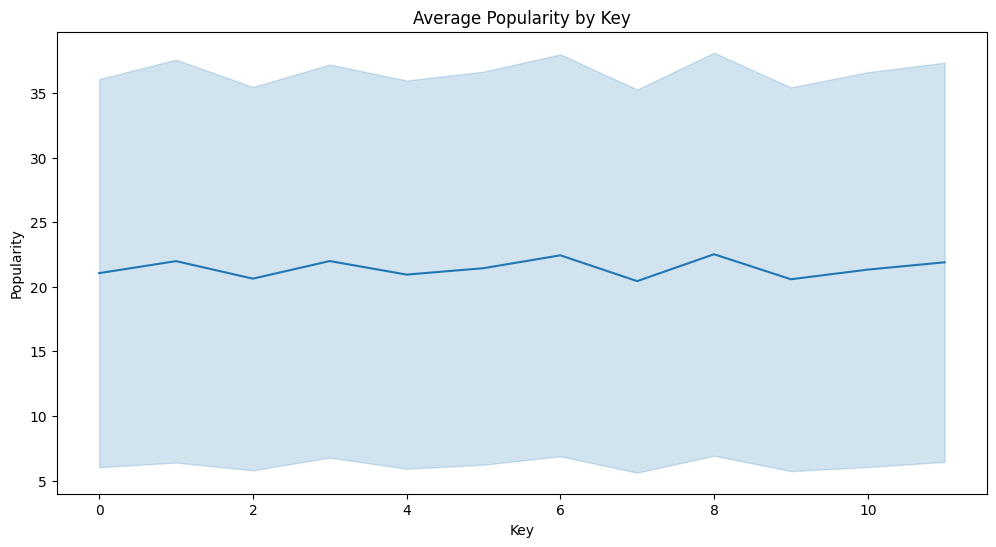

In [23]:
# key vs popularity line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='key', y='popularity', data=data, errorbar='sd')
plt.title('Average Popularity by Key')
plt.xlabel('Key')
plt.ylabel('Popularity')
plt.show()

In [24]:
# # popularity vs instrumentalness line plot
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='instrumentalness', y='popularity', data=data)
# plt.title('Popularity vs Instrumentalness')
# plt.xlabel('Instrumentalness')
# plt.ylabel('Popularity')
# plt.show()

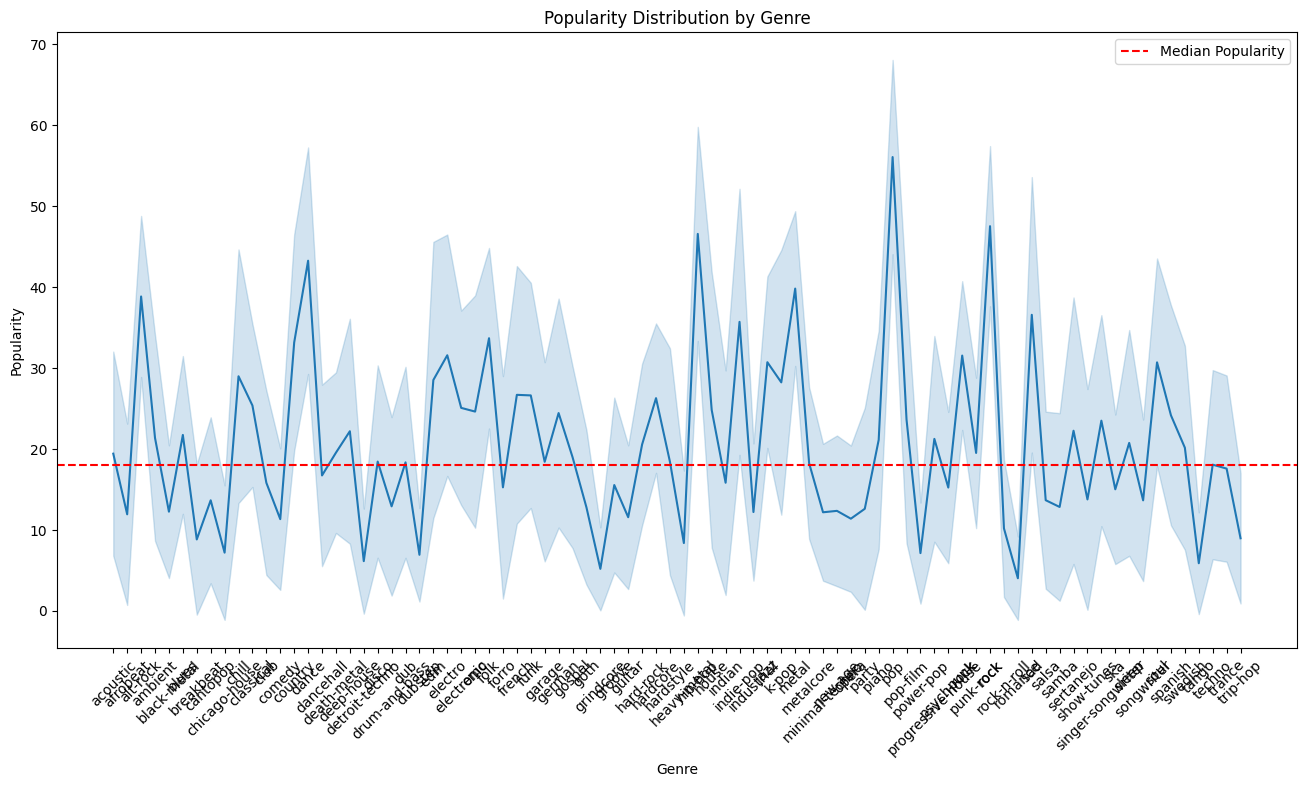

In [25]:
# popularity vs genre using line plot inside a large plot
plt.figure(figsize=(16, 8))
sns.lineplot(x='genre', y='popularity', data=data, errorbar='sd')
# add a red median line
median_popularity = data['popularity'].median()
plt.axhline(median_popularity, color='red', linestyle='--', label='Median Popularity')
plt.legend()
plt.title('Popularity Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Popularity')
plt.xticks(rotation=45)
plt.show()

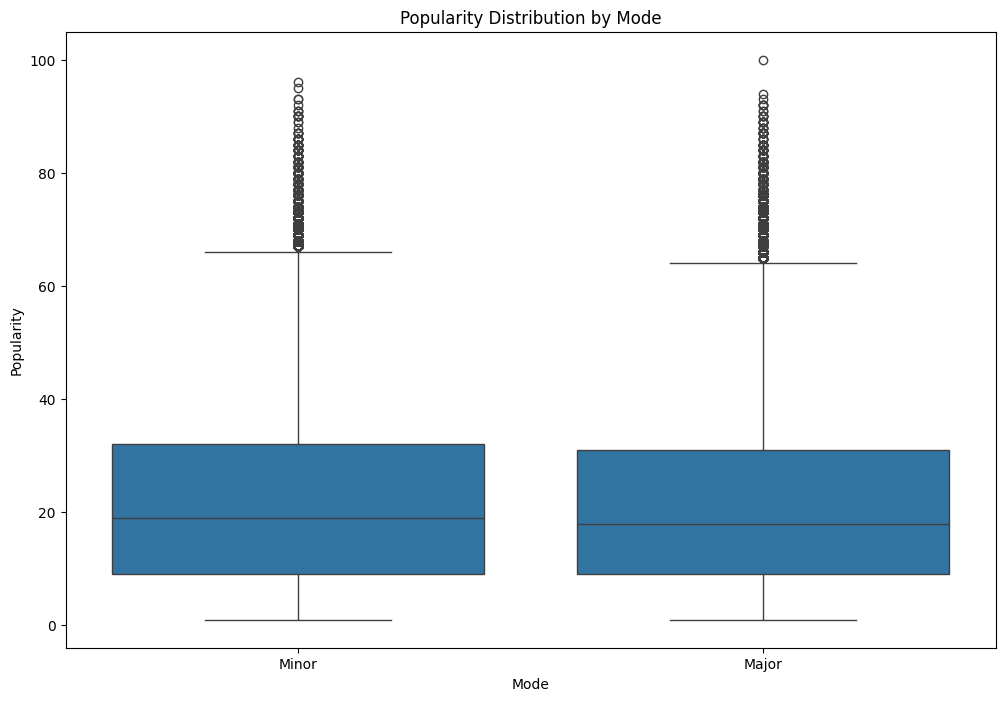

In [26]:
# popularity vs mode using box plot (1: major, 0: minor)
plt.figure(figsize=(12, 8))
sns.boxplot(x='mode', y='popularity', data=data)
plt.title('Popularity Distribution by Mode')
plt.xlabel('Mode')
plt.ylabel('Popularity')
plt.xticks([0, 1], ['Minor', 'Major'])
plt.show()

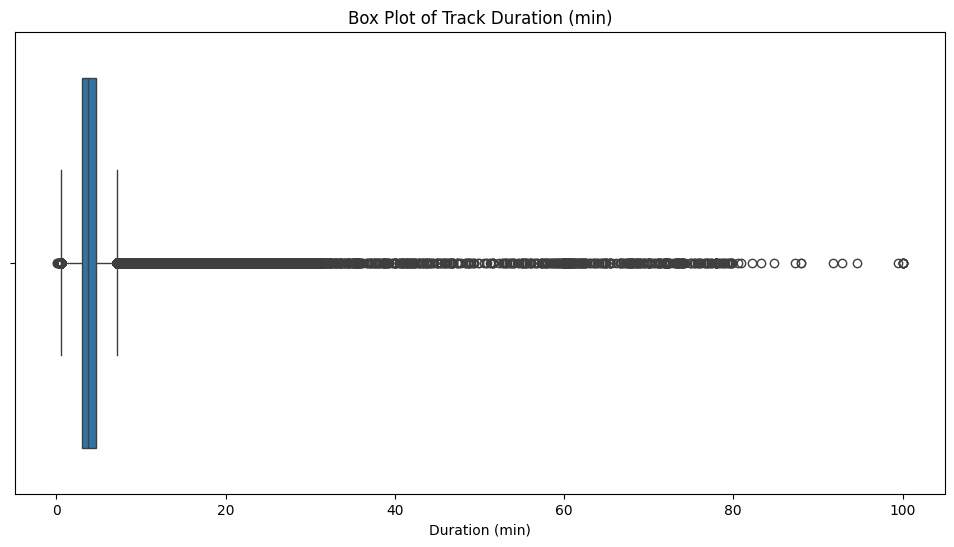

In [27]:
# duration in ms outliers detection using box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['duration_ms']/60000)
plt.title('Box Plot of Track Duration (min)')
plt.xlabel('Duration (min)')
plt.show()

In [28]:
# calculate the quantiles for duration_ms
Q1 = data['duration_ms'].quantile(0.25)
Q3 = data['duration_ms'].quantile(0.75)
Q4 = data['duration_ms'].quantile(0.95)
IQR = Q3 - Q1
print(f"Q1: {Q1}, Q3: {Q3}, Q4: {Q4}")

Q1: 181707.0, Q3: 281298.0, Q4: 436107.0


In [29]:
# add feature normal vs long duration
data['long_duration'] = data['duration_ms'].apply(lambda x: 1 if x > Q4 else 0)

# add feature normal vs short duration
data['short_duration'] = data['duration_ms'].apply(lambda x: 1 if x < Q1 else 0)

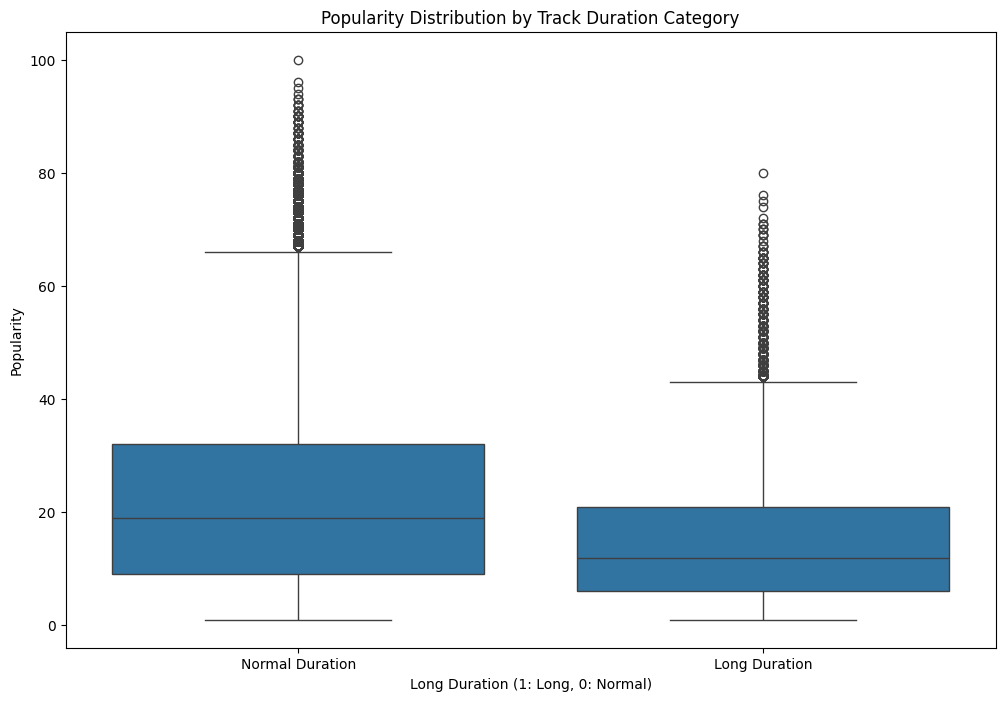

In [30]:
# long_duration vs popularity box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='long_duration', y='popularity', data=data)
plt.title('Popularity Distribution by Track Duration Category')
plt.xlabel('Long Duration (1: Long, 0: Normal)')
plt.ylabel('Popularity')
plt.xticks([0, 1], ['Normal Duration', 'Long Duration'])
plt.show()

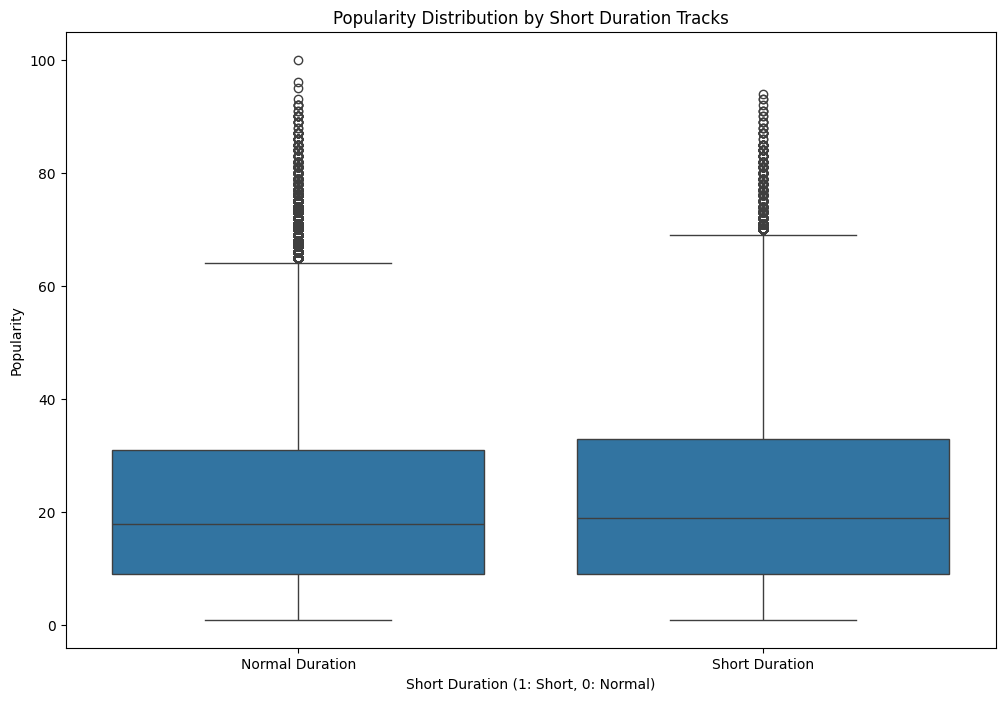

In [31]:
# plot short_duration vs popularity box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='short_duration', y='popularity', data=data)
plt.title('Popularity Distribution by Short Duration Tracks')
plt.xlabel('Short Duration (1: Short, 0: Normal)')
plt.ylabel('Popularity')
plt.xticks([0, 1], ['Normal Duration', 'Short Duration'])
plt.show()

In [32]:
# # duration vs popularity line plot using sd error bars
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='duration_ms', y='popularity', data=data, errorbar='sd')
# plt.title('Duration vs Popularity')
# plt.xlabel('Duration (ms)')
# plt.ylabel('Popularity')
# plt.show()

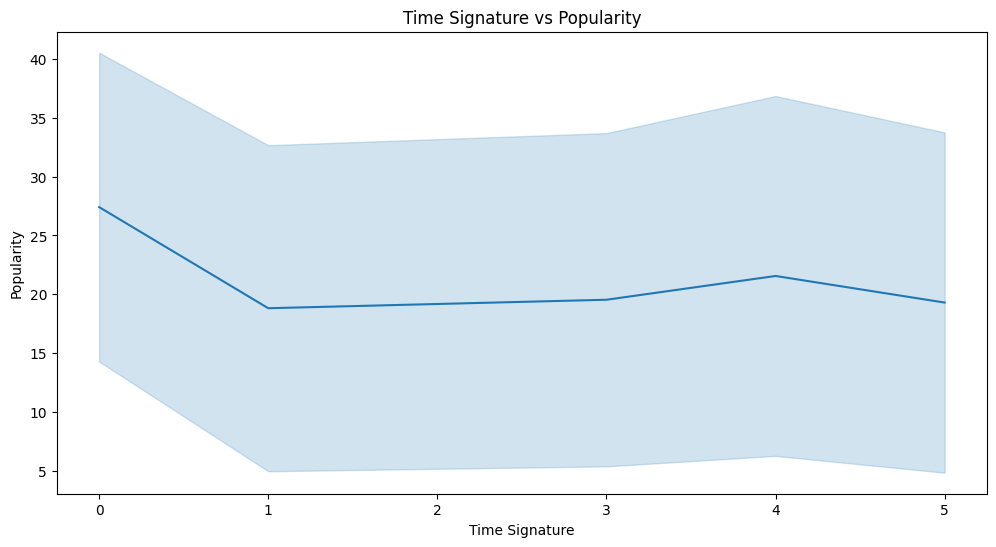

In [33]:
# time signature vs popularity line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='time_signature', y='popularity', data=data, errorbar='sd')
plt.title('Time Signature vs Popularity')
plt.xlabel('Time Signature')
plt.ylabel('Popularity')
plt.show()

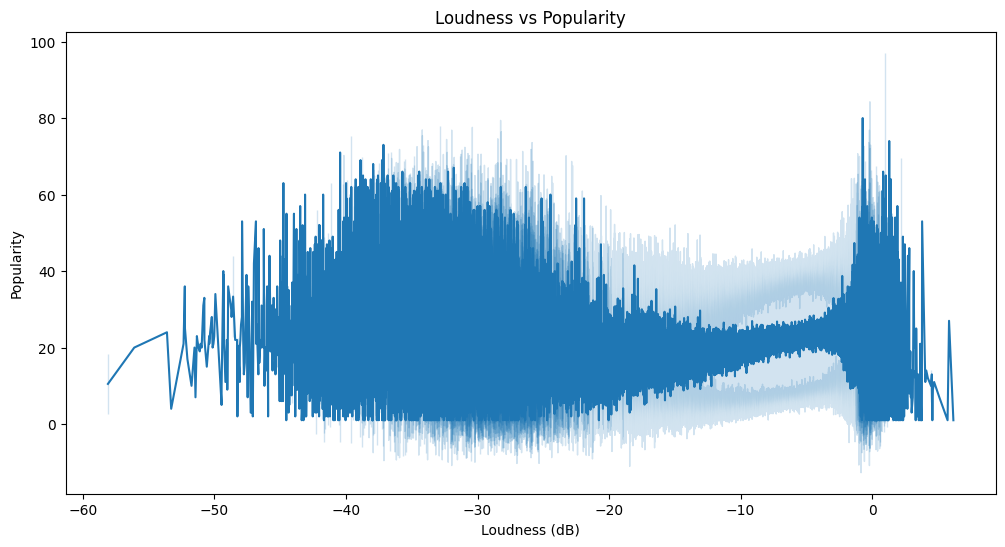

In [34]:
# loudness vs popularity line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='loudness', y='popularity', data=data, errorbar='sd')
plt.title('Loudness vs Popularity')
plt.xlabel('Loudness (dB)')
plt.ylabel('Popularity')
plt.show()  

In [35]:
# percentage of tracks with 0 popularity
num_zero_popularity = data[data['popularity'] == 0].shape[0]
percentage_zero_popularity = (num_zero_popularity / data.shape[0]) * 100
print(f"Percentage of tracks with 0 popularity: {percentage_zero_popularity:.2f}%")

Percentage of tracks with 0 popularity: 0.00%


In [36]:
# nbr of tracks with popularity >=95
num_max_popularity = data[data['popularity'] >= 95].shape[0]
print(f"Number of tracks with popularity >=95: {num_max_popularity}")
percentage_max_popularity = (num_max_popularity / data.shape[0]) * 100
print(f"Percentage of tracks with popularity >=95: {percentage_max_popularity:.2f}%")

Number of tracks with popularity >=95: 3
Percentage of tracks with popularity >=95: 0.00%


# III. Modeling

## III.a. Random model (Base line)

In [37]:
# create a model that randomly predicts the popularity based on the distribution of popularity in the dataset

mean_popularity = data['popularity'].mean()
std_popularity = data['popularity'].std()

data['random_popularity'] = np.random.normal(mean_popularity, std_popularity, size=len(data))
data['random_verdict'] = (data['random_popularity'] > POPULARITY_THRESHOLD).astype(int)

In [38]:
# calculate precision, recall, f1-score
print("Classification Report for Random Model:")
print(classification_report(data['verdict'], data['random_verdict']))

Classification Report for Random Model:
              precision    recall  f1-score   support

           0       0.84      1.00      0.92    844801
           1       0.06      0.00      0.00    156556

    accuracy                           0.84   1001357
   macro avg       0.45      0.50      0.46   1001357
weighted avg       0.72      0.84      0.77   1001357



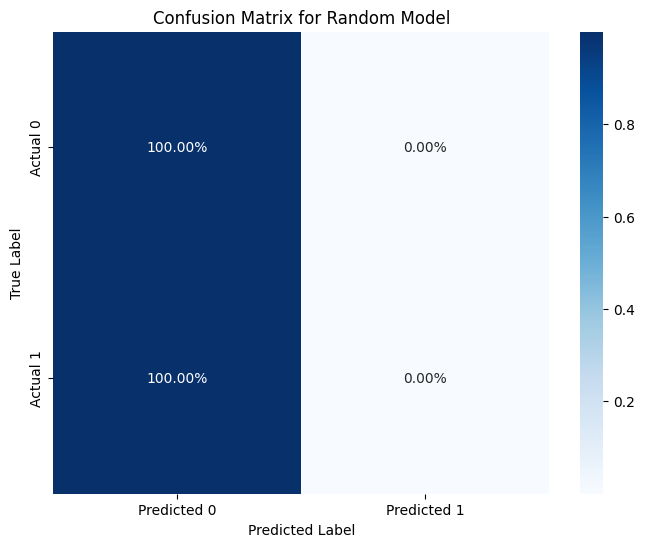

In [39]:
# confusion matrix using percentage
conf_matrix = confusion_matrix(data['verdict'], data['random_verdict'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix / conf_matrix.sum(axis=1)[:, None], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Random Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

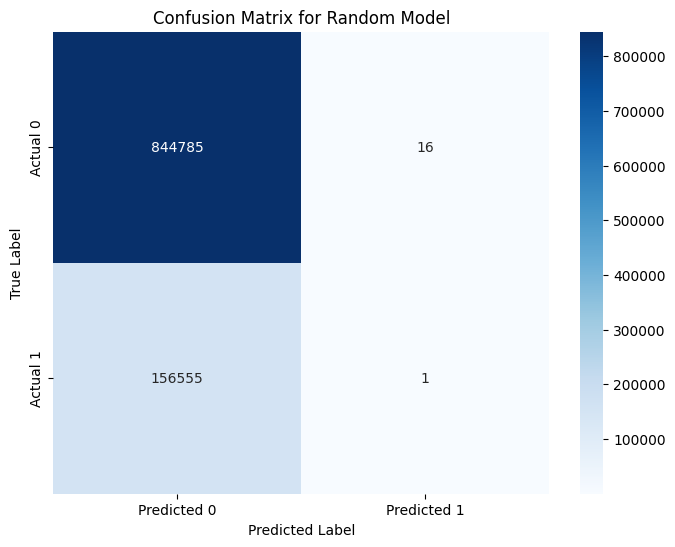

In [40]:
# confusion matrix using absolute numbers
conf_matrix = confusion_matrix(data['verdict'], data['random_verdict'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Random Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# III.b. simple tree

In [41]:
def hot_encode_column(df, column_name) -> pd.DataFrame:
    """
    One-hot encode a categorical column in the dataframe.
    """
    one_hot = pd.get_dummies(df[column_name], prefix=column_name).astype(int)
    df = df.drop(column_name, axis=1)
    df = df.join(one_hot)
    return df

In [42]:
# build a simple decision tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

features = data.drop(columns=['popularity', 'verdict', 'random_popularity', 'random_verdict'])
features = features.drop(columns=['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'year'])
features.dropna(inplace=True)

features = hot_encode_column(features, 'genre')

X_train, X_test, y_train, y_test = train_test_split(features, data['verdict'], test_size=0.2, random_state=SEED)
features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,genre_ska,genre_sleep,genre_songwriter,genre_soul,genre_spanish,genre_swedish,genre_tango,genre_techno,genre_trance,genre_trip-hop
0,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,...,0,0,0,0,0,0,0,0,0,0
1,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,...,0,0,0,0,0,0,0,0,0,0
2,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,...,0,0,0,0,0,0,0,0,0,0
3,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,...,0,0,0,0,0,0,0,0,0,0
4,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,...,0,0,0,0,0,0,0,0,0,0


In [43]:
X_test.shape

(200272, 98)

In [44]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200272 entries, 579522 to 887299
Data columns (total 98 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   danceability             200272 non-null  float64
 1   energy                   200272 non-null  float64
 2   key                      200272 non-null  int64  
 3   loudness                 200272 non-null  float64
 4   mode                     200272 non-null  int64  
 5   speechiness              200272 non-null  float64
 6   acousticness             200272 non-null  float64
 7   instrumentalness         200272 non-null  float64
 8   liveness                 200272 non-null  float64
 9   valence                  200272 non-null  float64
 10  tempo                    200272 non-null  float64
 11  duration_ms              200272 non-null  int64  
 12  time_signature           200272 non-null  int64  
 13  artist_song_count        200272 non-null  int64  
 14  long

In [45]:
model = DecisionTreeClassifier(random_state=SEED, class_weight='balanced', max_depth=5)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [46]:
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Decision Tree Model Accuracy: {accuracy:.2f}")
print("Classification Report for Decision Tree Model:")
print(classification_report(y_test, predictions))

Decision Tree Model Accuracy: 0.87
Classification Report for Decision Tree Model:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93    168858
           1       0.71      0.29      0.41     31414

    accuracy                           0.87    200272
   macro avg       0.80      0.64      0.67    200272
weighted avg       0.86      0.87      0.85    200272



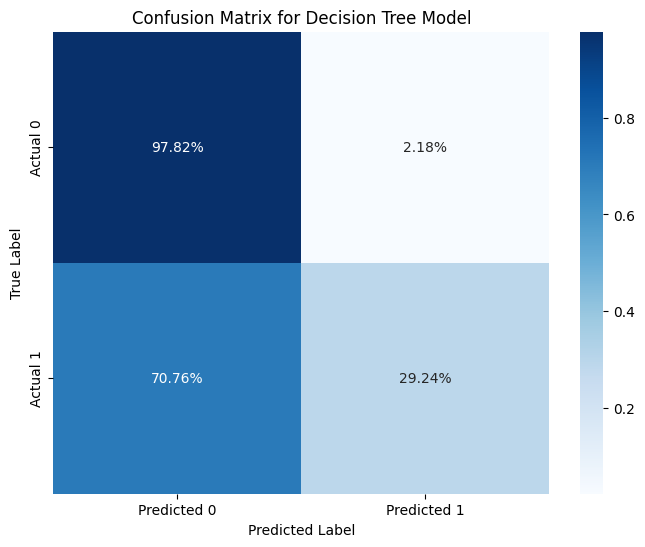

In [47]:
# confusion matrix with percentage
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix / conf_matrix.sum(axis=1)[:, None], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Decision Tree Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

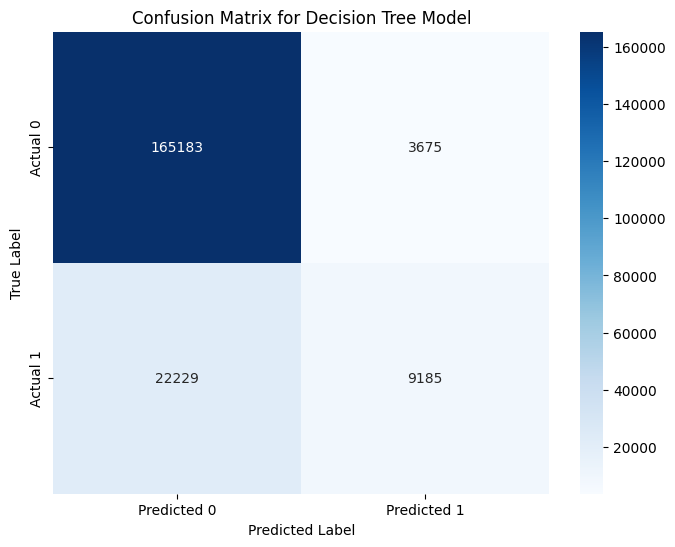

In [48]:
# confusion matrix with absolute numbers
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Decision Tree Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

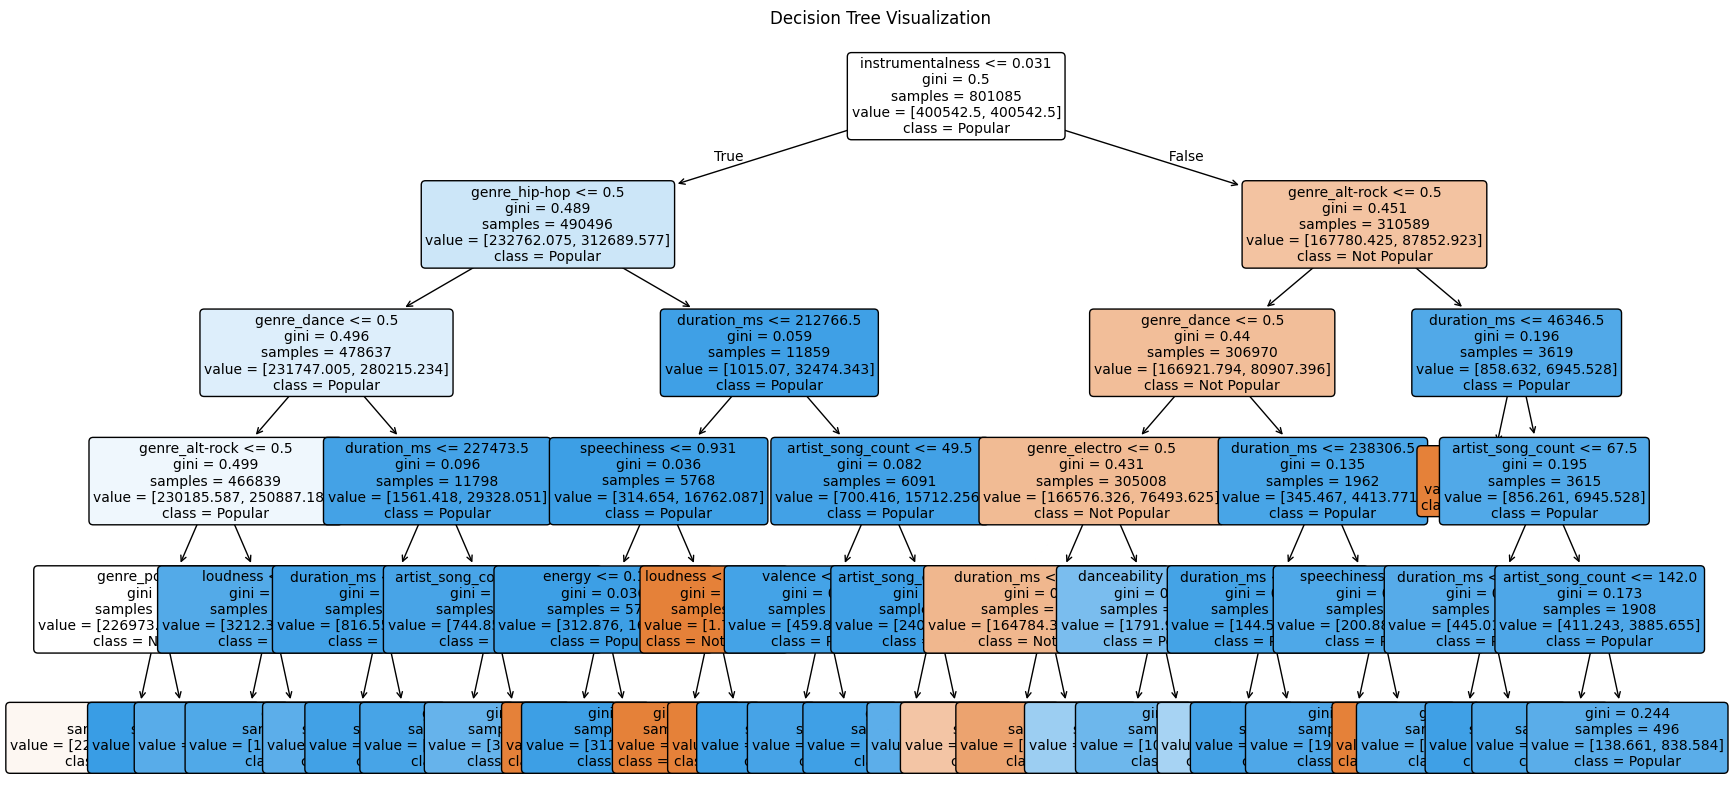

In [49]:
# display the tree, i want to see the set of rules used by the tree

from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=features.columns, class_names=['Not Popular', 'Popular'], rounded=True, fontsize=10)
plt.title('Decision Tree Visualization')
plt.show()

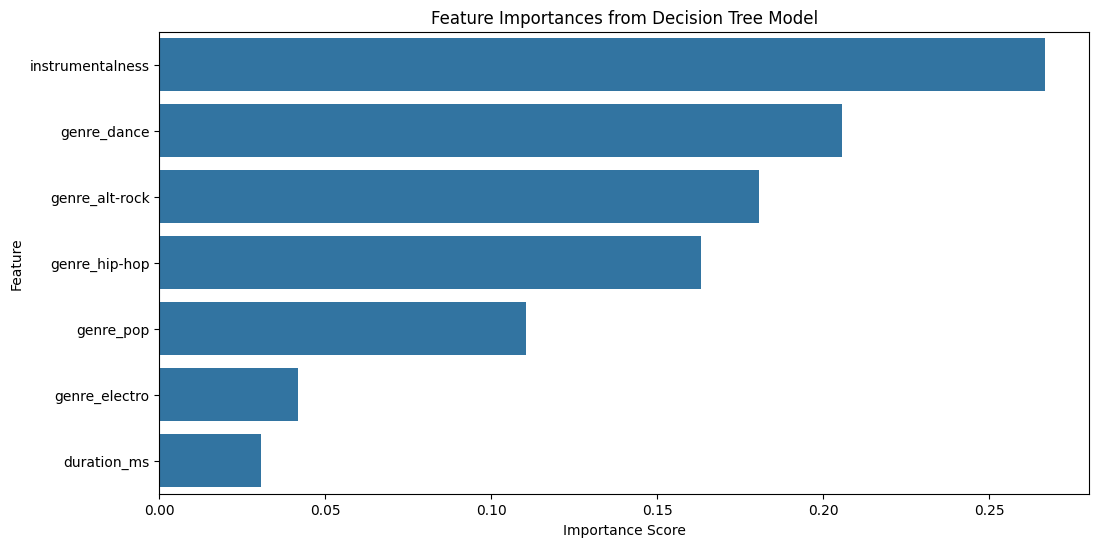

In [50]:
# display feature importance
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
# keep only features with importance > 0.01
feature_importances = feature_importances[feature_importances > 0.01]
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importances from Decision Tree Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [51]:
# get the depth of the tree
tree_depth = model.get_depth()
print(f"Depth of the Decision Tree: {tree_depth}")

Depth of the Decision Tree: 5


## III.c. Random forest

In [52]:
# build a random forest model
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=SEED, class_weight='balanced', n_estimators=100, max_depth=5, max_features='sqrt', min_samples_split=10)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=10, random_state=42)

In [53]:
# messure rf_model performance
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Model Accuracy: {rf_accuracy:.2f}")
print("Classification Report for Random Forest Model:")
print(classification_report(y_test, rf_predictions))

Random Forest Model Accuracy: 0.69
Classification Report for Random Forest Model:
              precision    recall  f1-score   support

           0       0.93      0.69      0.79    168858
           1       0.30      0.71      0.42     31414

    accuracy                           0.69    200272
   macro avg       0.61      0.70      0.60    200272
weighted avg       0.83      0.69      0.73    200272



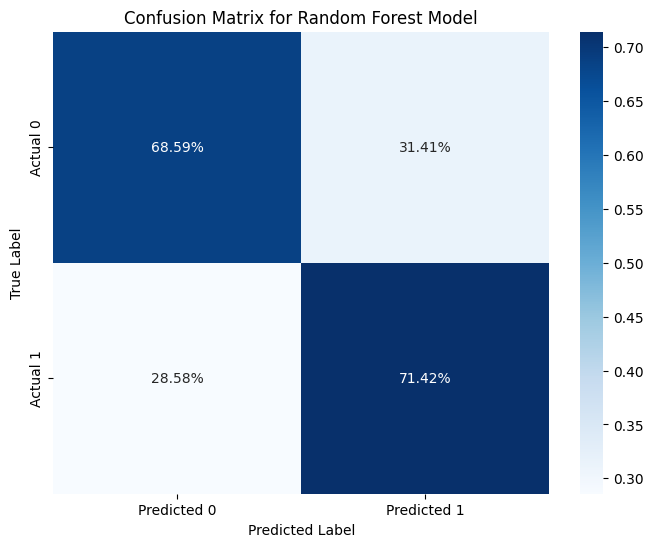

In [54]:
# confusion matrix with percentage
conf_matrix = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix / conf_matrix.sum(axis=1)[:, None], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

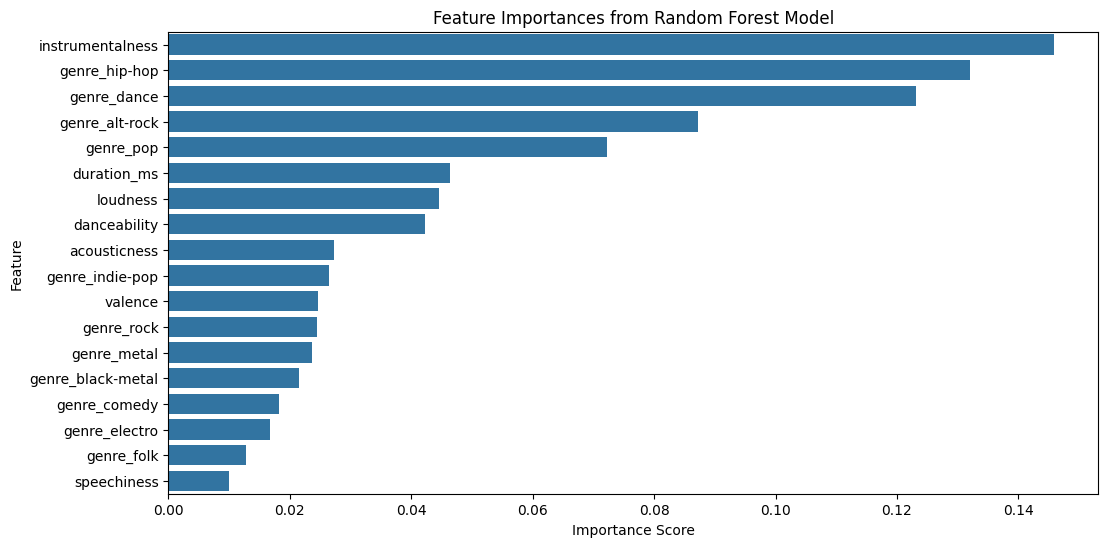

In [55]:
# feature importance for rf_model
rf_feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
rf_feature_importances = rf_feature_importances.sort_values(ascending=False)
# keep only features with importance > 0.01
rf_feature_importances = rf_feature_importances[rf_feature_importances > 0.01]
plt.figure(figsize=(12, 6))
sns.barplot(x=rf_feature_importances.values, y=rf_feature_importances.index)
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [56]:
# display the learning curve of the random forest the model
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, val_scores = learning_curve(
#     rf_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 8), random_state=SEED
# )
# plt.figure(figsize=(12, 6))
# plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score', marker='o')
# plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Score', marker='o')
# plt.title('Learning Curve for Random Forest Model')
# plt.xlabel('Training Set Size')
# plt.ylabel('F1 Score')
# plt.legend()


In [57]:
features = data.drop(columns=['popularity', 'verdict', 'random_popularity', 'random_verdict'])

In [58]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=SEED, 
                          objective='binary:logistic',
                          colsample_bytree=0.8, 
                          learning_rate=0.1, 
                          max_depth=6, 
                          n_estimators=1000, 
                          subsample=0.9, 
                          scale_pos_weight=6)

xgb_model.fit(X_train, y_train)

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/mahabub.ahmed.eee/Documents/MLOps/MLOps-Spotify/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <B111F8D5-6AC6-3245-A6B5-94693F6992AB> /Users/mahabub.ahmed.eee/Documents/MLOps/MLOps-Spotify/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [ ]:
# measure xgb_model performance
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Model Accuracy: {xgb_accuracy:.2f}")
print("Classification Report for XGBoost Model:")
print(classification_report(y_test, xgb_predictions))

XGBoost Model Accuracy: 0.79
Classification Report for XGBoost Model:
              precision    recall  f1-score   support

           0       0.96      0.79      0.86    168858
           1       0.41      0.80      0.54     31414

    accuracy                           0.79    200272
   macro avg       0.68      0.79      0.70    200272
weighted avg       0.87      0.79      0.81    200272



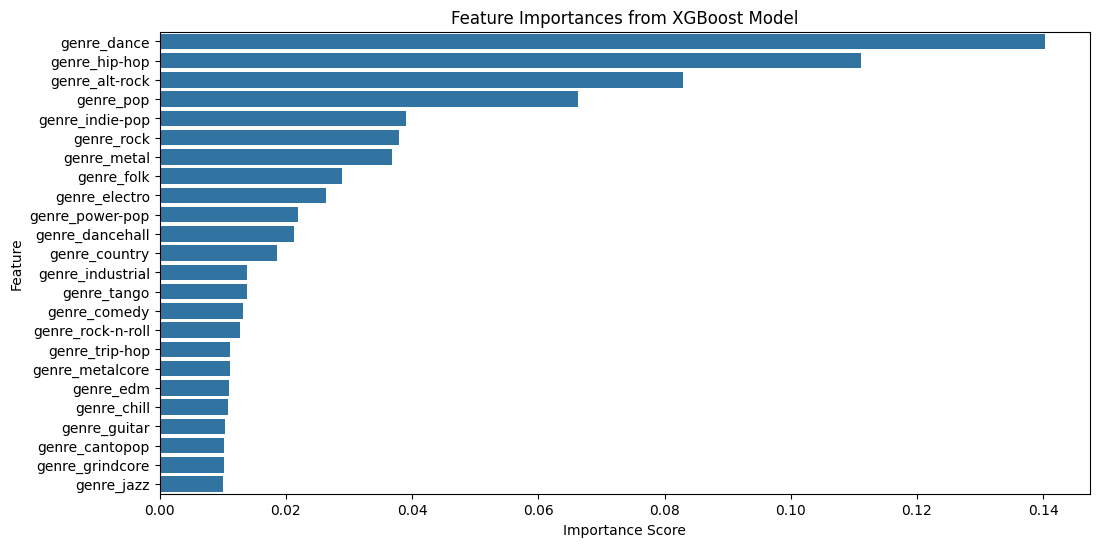

In [ ]:
# feature importance for xgb_model
xgb_feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
xgb_feature_importances = xgb_feature_importances.sort_values(ascending=False)
# keep only features with importance > 0.01
xgb_feature_importances = xgb_feature_importances[xgb_feature_importances > 0.01]
plt.figure(figsize=(12, 6))
sns.barplot(x=xgb_feature_importances.values, y=xgb_feature_importances.index)
plt.title('Feature Importances from XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [ ]:
# # check feature permutation importance for xgb_model
# from sklearn.inspection import permutation_importance
# perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=SEED, n_jobs=-1)
# perm_importance_series = pd.Series(perm_importance.importances_mean, index=X_test.columns)
# perm_importance_series = perm_importance_series.sort_values(ascending=False)
# # keep only features with importance > 0.0001
# perm_importance_series = perm_importance_series[perm_importance_series > 0.0001]
# plt.figure(figsize=(12, 6))
# sns.barplot(x=perm_importance_series.values, y=perm_importance_series.index)
# plt.title('Permutation Feature Importances from XGBoost Model')
# plt.xlabel('Importance Score')
# plt.ylabel('Feature')
# plt.show()

In [ ]:
# genre_cols = [col for col in X_test.columns if col.startswith('genre_')]
# genre_importance = perm_importance.importances_mean[[X_test.columns.get_loc(c) for c in genre_cols]].sum()
# print("Total importance of genre features:", genre_importance)


In [ ]:
# X_no_genre = X_train.drop(columns=genre_cols)

# xgb_model.fit(X_train, y_train)
# print(xgb_model.score(X_test, y_test))

# xgb_model.fit(X_no_genre, y_train)
# X_no_genre_test = X_test.drop(columns=genre_cols)
# print(xgb_model.score(X_no_genre_test, y_test))


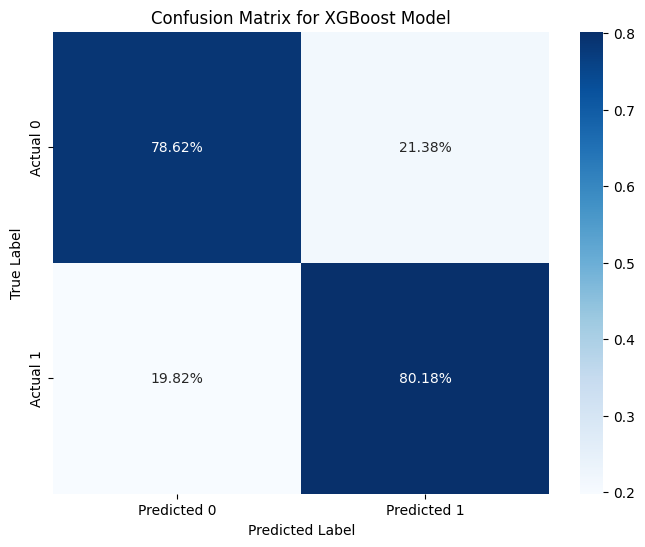

In [ ]:
# confusion matrix with percentage
conf_matrix = confusion_matrix(y_test, xgb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix / conf_matrix.sum(axis=1)[:, None], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

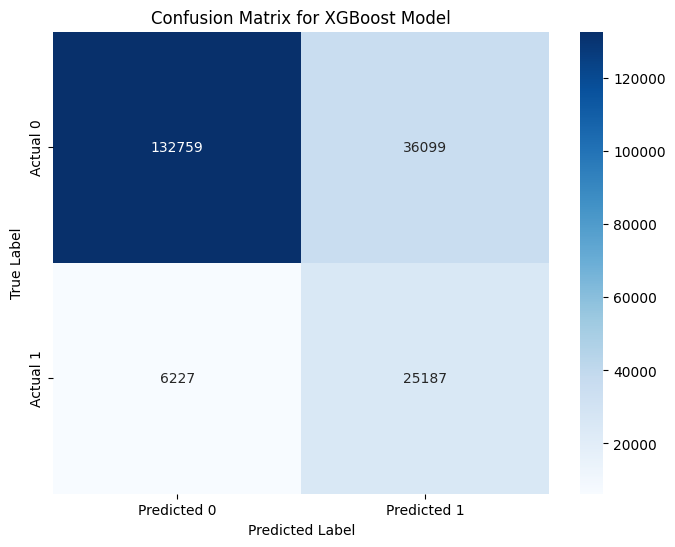

In [ ]:
# confusion matrix with absolute numbers
conf_matrix = confusion_matrix(y_test, xgb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

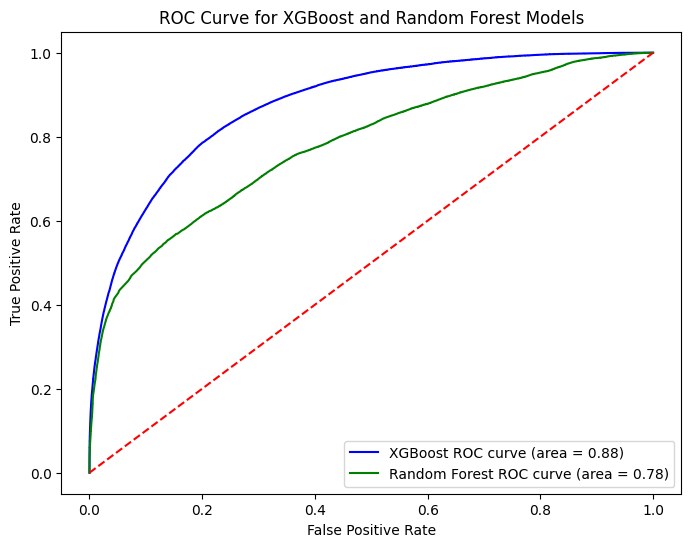

In [ ]:
# ROC curve for xgb_model and random forest_model
from sklearn.metrics import roc_curve, auc
y_probs = xgb_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)
rf_roc_auc = auc(rf_fpr, rf_tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'XGBoost ROC curve (area = {roc_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='green', label=f'Random Forest ROC curve (area = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve for XGBoost and Random Forest Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Calculate the best Threshold for popularity

In [ ]:
def constrained_score(y_true, y_pred):
    prec = precision_score(y_true, y_pred, pos_label=1)
    rec  = recall_score(y_true, y_pred, pos_label=1)

    # Hard constraints
    if rec < RECALL_THRESHOLD or prec < PRECISION_THRESHOLD:
        return 0.0

    # Smooth reward zone once constraints are satisfied
    # You can tweak the weights
    return 0.5 * prec + 0.5 * rec

In [ ]:
# create a function that run an xgboost model for all thresholds from 50 to 70 and return the best threshold based on the average of recalls
def find_best_threshold(data, start=50, end=70):
    best_threshold = start
    best_recall_avg = 0.0
    delta_recalls = 0.0
    score = 0.0
    best_recall_avg_lst = []
    deltas_lst = []
    scores_lst = []
    scorer = make_scorer(constrained_score, greater_is_better=True)

    for threshold in range(start, end + 1):
        print(f"Evaluating threshold: {threshold}")
        data['verdict'] = (data['popularity'] > threshold).astype(int)
        X = data.drop(columns=['popularity', 'verdict', 'random_popularity', 'random_verdict'])
        X = X.drop(columns=['Unnamed: 0', 'artist_name', 'track_name', 'track_id', 'year'])
        X = hot_encode_column(X, 'genre')
        y = data['verdict']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

        xgb_model = XGBClassifier(random_state=SEED, 
                                  objective='binary:logistic',
                                  colsample_bytree=0.8, 
                                  learning_rate=0.1,
                                  max_depth=6, 
                                  n_estimators=600, 
                                  subsample=0.9, 
                                  scale_pos_weight=30, n_jobs=-1)
        
        xgb_model.fit(X_train, y_train)
        predictions = xgb_model.predict(X_test)

        report = classification_report(y_test, predictions, output_dict=True)
        recall_avg = (report['1']['recall'] + report['0']['recall']) / 2
        delta_recalls = report['1']['recall'] - report['0']['recall']
        score = scorer(xgb_model, X_test, y_test)

        best_recall_avg_lst.append(recall_avg)
        deltas_lst.append(delta_recalls)
        scores_lst.append(score)

        print(f"Threshold: {threshold}, Average Recall: {recall_avg:.2f}, Delta Recalls: {delta_recalls:.2f}, Score: {score:.2f}")

        if recall_avg > best_recall_avg:
            best_recall_avg = recall_avg
            best_threshold = threshold

    return best_threshold, best_recall_avg, best_recall_avg_lst, deltas_lst, scores_lst

In [ ]:
# start_threshold = 44
# end_threshold = 55
# best_threshold, best_recall, best_recall_avg_lst, deltas_lst, scores_lst = find_best_threshold(data, start=start_threshold, end=end_threshold)
# print(f"Best Threshold: {best_threshold} with Average Recall: {best_recall:.2f}")

# # plot a graph of best_recall_avg_lst vs thresholds and deltas_lst vs thresholds on the same plot with two y axes
# thresholds = list(range(start_threshold, end_threshold + 1))
# fig, ax1 = plt.subplots(figsize=(12, 6))
# ax1.plot(thresholds, best_recall_avg_lst, color='blue', marker='o', label='Average Recall')
# ax1.set_xlabel('Popularity Threshold')
# ax1.set_ylabel('Average Recall', color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax2 = ax1.twinx()
# ax2.plot(thresholds, deltas_lst, color='red', marker='x', label='Delta Recalls')
# ax2.set_ylabel('Delta Recalls', color='red')
# ax2.tick_params(axis='y', labelcolor='red')
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))
# ax3.plot(thresholds, scores_lst, color='green', marker='s', label='F2 Score')
# ax3.set_ylabel('F2 Score', color='green')
# ax3.tick_params(axis='y', labelcolor='green')
# # add legends
# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# lines_3, labels_3 = ax3.get_legend_handles_labels()
# ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left')
# fig.tight_layout()
# plt.title('Average Recall and Delta Recalls vs Popularity Threshold')
# plt.show()

## SearchGridCV

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(random_state=SEED, 
                          objective='binary:logistic',
                          n_jobs=-1)

# scorer = make_scorer(fbeta_score, beta=2)
scorer = make_scorer(constrained_score, greater_is_better=True)

param_grid = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [6],
    'learning_rate': [0.1],
    'subsample': [0.9],
    'colsample_bytree': [0.6, 0.8],
    'scale_pos_weight': [6, 12]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall_macro', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, scale_pos_weight=6, subsample=0.9; total time=  42.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, scale_pos_weight=12, subsample=0.9; total time=  43.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, scale_pos_weight=6, subsample=0.9; total time=  43.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, scale_pos_weight=12, subsample=0.9; total time=  43.2s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, scale_pos_weight=12, subsample=0.9; total time=  43.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=600, scale_pos_weight=6, subsample=0.9; total time=  43.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=6, n_estimators=800, scale_pos_weight=6, subsample=0.9; total time

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.6, 0.8], 'learning_rate': [0.1], 'max_depth': [6], 'n_estimators': [600, 800, ...], ...}"
,scoring,'recall_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [ ]:
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000, 'scale_pos_weight': 6, 'subsample': 0.9}


In [ ]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

In [ ]:
# evaluate the best model
print("Classification Report for Best XGBoost Model:")
print(classification_report(y_test, y_pred))

Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

           0       0.96      0.79      0.86    168858
           1       0.41      0.80      0.54     31414

    accuracy                           0.79    200272
   macro avg       0.68      0.79      0.70    200272
weighted avg       0.87      0.79      0.81    200272



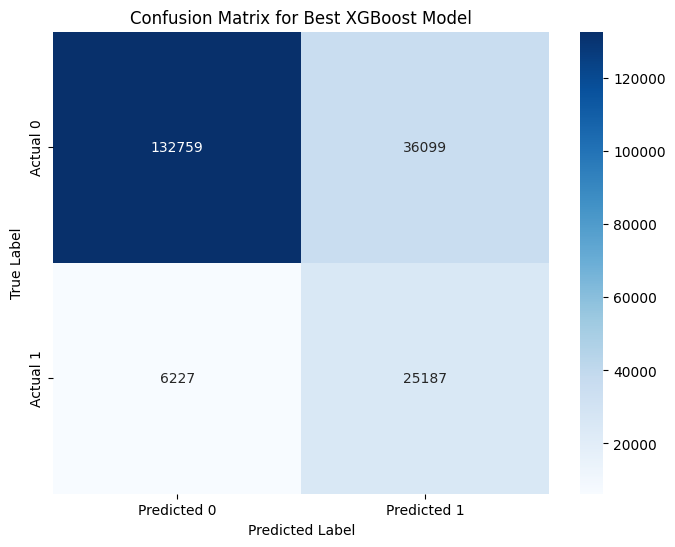

In [ ]:
#confusion matrix for the best model
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Best XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

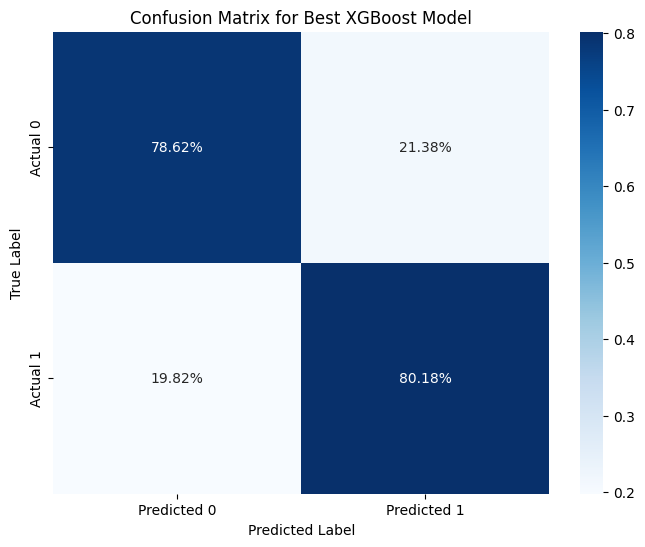

In [ ]:
#confusion matrix for the best model with percentage
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix / conf_matrix.sum(axis=1)[:, None], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Best XGBoost Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# precision of the best model for all classes total right answers / total predicted answers
precision_micro = precision_score(y_test, y_pred, average='micro')

print(f"Micro Average Precision: {precision_micro:.4f}")


Micro Average Precision: 0.7887


## III.d. KNN

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(features, data['popularity'], test_size=0.2, random_state=SEED)

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor

# knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='auto', metric='minkowski', p=2)
# knn_model.fit(X_train, y_train)

In [ ]:
# y_pred = knn_model.predict(X_test)
# y_pred = y_pred > POPULARITY_THRESHOLD
# y_pred = y_pred.astype(int)

# knn_accuracy = accuracy_score(y_test, y_pred)
# print(f"KNN Model Accuracy: {knn_accuracy:.2f}")
# print("Classification Report for KNN Model:")
# print(classification_report(y_test, y_pred))  

In [ ]:
# evaluate knn_model
# knn_predictions = knn_model.predict(X_test)
# knn_accuracy = accuracy_score(y_test, knn_predictions)
# print(f"KNN Model Accuracy: {knn_accuracy:.2f}")
# print("Classification Report for KNN Model:")
# print(classification_report(y_test, knn_predictions))  


In [ ]:
# confusion matrix for knn_model
# conf_matrix = confusion_matrix(y_test, knn_predictions)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix / conf_matrix.sum(axis=1)[:, None], annot=True, fmt='.2%', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
# plt.title('Confusion Matrix for KNN Model')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()